# Attendance

[The link to SEAts](https://goldsmithscollege.sharepoint.com/sites/intranet-supporting-students/SitePages/SEAtS--QR-codes-for-check-in.aspx?utm_campaign=SEAtS%20reminder%2027.09.22&utm_source=emailCampaign&utm_content=&utm_medium=email)

# Today

- ## RNNs
- ## NLP toolkit (text vectorisation, word embeddings)
- ## Transformers

# 10 Deep learning for timeseries

In [1]:
import os, sys, pathlib
import numpy as np

from matplotlib import pyplot as plt
from IPython.display import YouTubeVideo

import tensorflow as tf

In [6]:
# reminder: Colab code to mount your drive
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive') # 'My Drive' is the default name of Google Drives, change the rest accordingly!
    os.chdir('drive/My Drive/IS53024B-Artificial-Intelligence/6-text-and-sequences') 
    os.listdir() 

---

## 10.2 A temperature-forecasting example

Download the data
```bash
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip
```

#### Inspecting the data of the Jena weather dataset

In [16]:
base_dir = pathlib.Path("jena")
fname = base_dir / "jena_climate_2009_2016.csv"

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
for i, feature in enumerate(header):
    if feature == '"T (degC)"':
        print(f"{i:<2} | \033[1;3m{feature} ← temperature in °C\033[0m")
    else:
        print(f"{i:<2} | {feature}")

print()
print(f"{len(lines)} lines")

0  | "Date Time"
1  | "p (mbar)"
2  | "T (degC)" ← temperature in °C
3  | "Tpot (K)"
4  | "Tdew (degC)"
5  | "rh (%)"
6  | "VPmax (mbar)"
7  | "VPact (mbar)"
8  | "VPdef (mbar)"
9  | "sh (g/kg)"
10 | "H2OC (mmol/mol)"
11 | "rho (g/m**3)"
12 | "wv (m/s)"
13 | "max. wv (m/s)"
14 | "wd (deg)"

420451 lines


#### Parsing the data

In [17]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))   # (len minus the date)

if not os.path.isfile(base_dir / "temperature.npy") and not os.path.isfile(base_dir / "raw_data.npz"):
    print("loading dataset")
    for i, line in enumerate(lines):
        print(f"line {i}/{len(lines)}\r", end="")
        values = [float(x) for x in line.split(",")[1:]] # (don't take the date)
        temperature[i] = values[1]                       # temperature at index 1
        raw_data[i, :] = values[:]
    np.save(base_dir / "temperature.npy", temperature)   # save as binary data
    np.save(base_dir / "raw_data.npy", raw_data)         # (much faster reloads)
else:
    print("loading numpy files")    
    temperature = np.load(base_dir / "temperature.npy")
    raw_data = np.load(base_dir / "raw_data.npy")

loading numpy files


#### Plotting the temperature timeseries

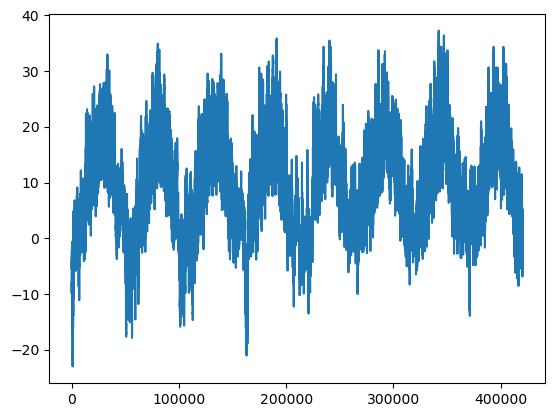

In [10]:
plt.plot(range(len(temperature)), temperature) # globally cyclical

#### Plotting the first 10 days of the temperature timeseries

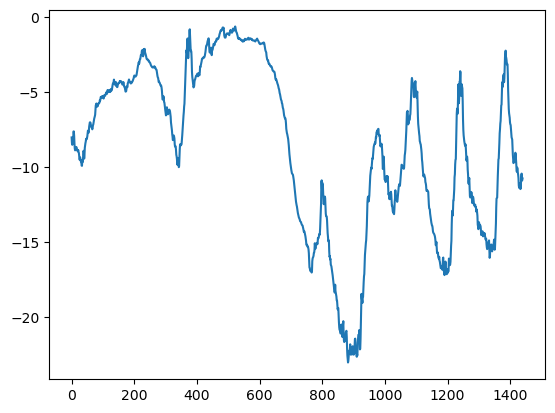

In [11]:
plt.plot(range(1440), temperature[:1440]) # locally much less so

#### Computing the number of samples we'll use for each data split

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


---

### 10.2.1 Preparing the data

#### Normalizing the data

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0) # we use the train data only to normalise
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

What will our dataset look like? A sequence, and a next step.

Documentation for [`tf.keras.utils.timeseries_dataset_from_array`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array).

In [5]:
int_sequence = np.arange(10)
dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],   # given our length, stop 3 before the end
    targets=int_sequence[3:], # the first target will be at the fourth element
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    print("-"*40)
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

----------------------------------------
[0, 1, 2] 3
[1, 2, 3] 4
----------------------------------------
[2, 3, 4] 5
[3, 4, 5] 6
----------------------------------------
[4, 5, 6] 7


#### Instantiating datasets for training, validation, and testing

In [9]:
sampling_rate = 6                                  # in the data, one sample every 10 mins: x 6 → one per hour
sequence_length = 120                              # the length of our sequence is 5 days (120 hours)
delay = sampling_rate * (sequence_length + 24 - 1) # target is 24h after the end of the sequence (one day after)
batch_size = 256

train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],           # not beyond `delay` steps before the end (that's our targets)
    targets=temperature[delay:], # first traget will start at `delay` step after the start
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,                           # start after train
    end_index=num_train_samples + num_val_samples
)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples         # start after train & val
)

#### Inspecting the output of one of our datasets

In [32]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


---

### 10.2.2 A common-sense, non-machine-learning baseline

What would that look like for continuous data, like temperature?

The assumption that Chollet makes is that there will be cycles of 24h (days!).

The temperature 24 hours in the future is likely close to the temperature now.

(Maybe a dubious assumption for UK weather?!)

This is similar to the Boston Housing dataset example we had: calculate the Mean Absolute Error (MAE).

#### Computing the common-sense baseline MAE

In [33]:
def evaluate_naive_method(dataset):
    """Evaluation: the target (in 24h) is identical to the last temperature measurement"""
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        #                   ┌ (the last sample, as our shape is: [samples, step, feature])
        #                   ↓ (↓ feature at index 1: temperature) 
        preds = samples[:, -1, 1] * std[1] + mean[1]     # unnormalize, same mean/std as in training
        total_abs_err += np.sum(np.abs(preds - targets)) # absolute distance between current & in 24h
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Can we beat this baseline? 

A common sense baseline is essential – otherwise we cannot calibrate the performance of any model.

An ML baseline – a simple, cheap model – is also useful.

Our focus is: **are sophisticated models worth the extra computational effort?**

---
### 10.2.3 Let's try a basic machine-learning model

Our baseline model is a two layer (plus flattening layer) fully-connected feedforward network.

#### Regression task

The final layer has a single unit without activation.

#### Loss
Mean Squared Error (MSE)

#### Metric

Mean Average Error, so results are directly comparable to the common-sense baseline.

#### Training and evaluating a densely connected model

In [14]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(16, activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_dense.keras",
        save_best_only=True
    )
]

model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 32s 36ms/step - loss: 14.2468 - mae: 2.9106 - val_loss: 11.7265 - val_mae: 2.7297
Epoch 2/10
819/819 [==============================] - 30s 37ms/step - loss: 9.9664 - mae: 2.4799 - val_loss: 10.4011 - val_mae: 2.5661
Epoch 3/10
819/819 [==============================] - 29s 36ms/step - loss: 9.1302 - mae: 2.3762 - val_loss: 11.1691 - val_mae: 2.6599
Epoch 4/10
819/819 [==============================] - 30s 37ms/step - loss: 8.5962 - mae: 2.3059 - val_loss: 10.6564 - val_mae: 2.5854
Epoch 5/10
819/819 [==============================] - 27s 33ms/step - loss: 8.2119 - mae: 2.2572 - val_loss: 13.5933 - val_mae: 2.9318
Epoch 6/10
819/819 [==============================] - 28s 34ms/step - loss: 7.9283 - mae: 2.2196 - val_loss: 10.4336 - val_mae: 2.5704
Epoch 7/10
819/819 [==============================] - 28s 34ms/step - loss: 7.7084 - mae: 2.1909 - val_loss: 10.6691 - val_mae: 2.5969
Epoch 8/10
819/819 [==============================] - 

In [20]:
model = tf.keras.models.load_model(base_dir / "jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 12s 28ms/step - loss: 11.7926 - mae: 2.6947
Test MAE: 2.69


We haven't beaten the common sense baseline!

The model is worse than common sense.

The machine is not privy to the wealth of human experiential evidence.

But why hasn't the machine found our simple model: that tomorrow's temperature will be pretty similar to today's? 


The hypothesis space is the space of all two layer networks.

Already a very complicated space.

The simple baseline might hidden in a tiny corner of this vast, intricate hypothesis space.

ML limitation: parameter learning can fail to find a simple solution to a simple problem.

Of course we could hard-code models to look for a specific kind of solution but we wish to avoid excessive feature engineering.

#### Plotting results

In [10]:
def plot_history(history):
    loss = history.history["mae"]
    val_loss = history.history["val_mae"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, label="Training MAE")
    plt.plot(epochs, val_loss, label="Validation MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()

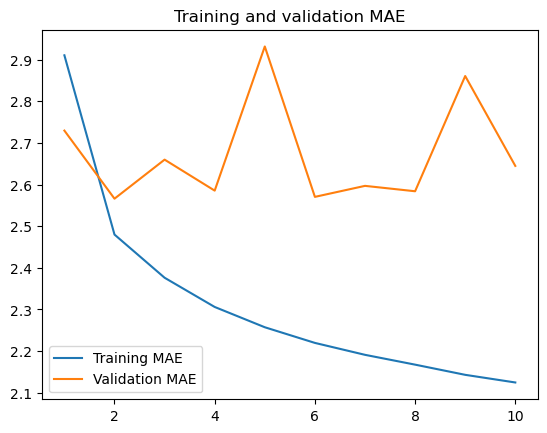

In [22]:
plot_history(history)

---

### 10.2.4 Let's try a 1D convolutional model

Convnets extract and modularise salient 2D information from local patches.

1D data – timeseries – might have similar local regularities.

And then 1D convnets would provide a cheap alternative to RNNs.

1D Pooling works just like 2D pooling – max (or average) pooling.

Used for subsampling – reducing the length of 1D inputs.

<!-- <img src="images/convolutions/1d-conv.png"> -->
<img src="https://drive.google.com/uc?id=15UzU-Vs6DsrNJokaXAoQJnIKAXukG4Le">

<small>[Castro et al., "STConvS2S: Spatiotemporal Convolutional Sequence to Sequence Network for weather forecasting", ResearchGate](https://www.researchgate.net/figure/Causal-convolution-operation-in-a-1D-convolutional-layer-with-k-3-kernel-size-Input_fig1_337703712)</small>

In [25]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# note the larger convolution window: 24
x = tf.keras.layers.Conv1D(8, 24, activation="relu")(inputs)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Conv1D(8, 12, activation="relu")(x)
x = tf.keras.layers.MaxPooling1D(2)(x)
x = tf.keras.layers.Conv1D(8, 6, activation="relu")(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_conv.keras",
        save_best_only=True
    )
]

model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 37s 42ms/step - loss: 22.6764 - mae: 3.7402 - val_loss: 17.2227 - val_mae: 3.3239
Epoch 2/10
819/819 [==============================] - 30s 37ms/step - loss: 15.8596 - mae: 3.1847 - val_loss: 17.1841 - val_mae: 3.2985
Epoch 3/10
819/819 [==============================] - 33s 40ms/step - loss: 14.5838 - mae: 3.0461 - val_loss: 14.8074 - val_mae: 3.0218
Epoch 4/10
819/819 [==============================] - 32s 38ms/step - loss: 13.6190 - mae: 2.9363 - val_loss: 19.1734 - val_mae: 3.4623
Epoch 5/10
819/819 [==============================] - 28s 33ms/step - loss: 12.9764 - mae: 2.8631 - val_loss: 14.3195 - val_mae: 2.9808
Epoch 6/10
819/819 [==============================] - 31s 38ms/step - loss: 12.4982 - mae: 2.8070 - val_loss: 19.2121 - val_mae: 3.4513
Epoch 7/10
819/819 [==============================] - 31s 38ms/step - loss: 12.1809 - mae: 2.7697 - val_loss: 15.7789 - val_mae: 3.1094
Epoch 8/10
819/819 [============================

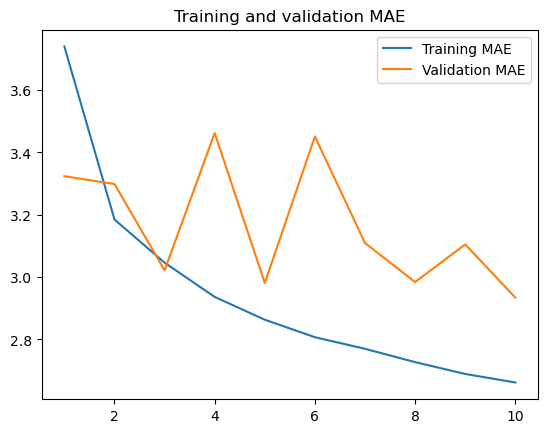

In [27]:
plot_history(history)

In [24]:
model = tf.keras.models.load_model(base_dir / "jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
del model # Not as good performance as the baseline or RNNs/LSTMs, but cheaper to run!

405/405 [==============================] - 14s 25ms/step - loss: 14.8517 - mae: 3.0467
Test MAE: 3.05


---

### 10.2.5 A first recurrent baseline

Perhaps causality and order matter (weather is not actually random, but follows day-by-day patterns).

We need an order-preserving model – an RNN.

#### A simple LSTM-based model

In [28]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.LSTM(16)(inputs) # ← our LSTM
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [29]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_lstm.keras",
        save_best_only=True
    )
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 38s 39ms/step - loss: 37.2632 - mae: 4.4338 - val_loss: 11.6923 - val_mae: 2.6286
Epoch 2/10
819/819 [==============================] - 34s 41ms/step - loss: 10.9944 - mae: 2.5781 - val_loss: 9.6755 - val_mae: 2.4259
Epoch 3/10
819/819 [==============================] - 32s 39ms/step - loss: 9.9950 - mae: 2.4591 - val_loss: 9.8242 - val_mae: 2.4123
Epoch 4/10
819/819 [==============================] - 30s 36ms/step - loss: 9.6236 - mae: 2.4104 - val_loss: 9.2215 - val_mae: 2.3570
Epoch 5/10
819/819 [==============================] - 32s 39ms/step - loss: 9.3747 - mae: 2.3749 - val_loss: 9.2315 - val_mae: 2.3612
Epoch 6/10
819/819 [==============================] - 33s 39ms/step - loss: 9.1929 - mae: 2.3506 - val_loss: 9.3484 - val_mae: 2.3779
Epoch 7/10
819/819 [==============================] - 32s 39ms/step - loss: 9.0145 - mae: 2.3268 - val_loss: 9.4529 - val_mae: 2.3904
Epoch 8/10
819/819 [==============================] - 32s 3

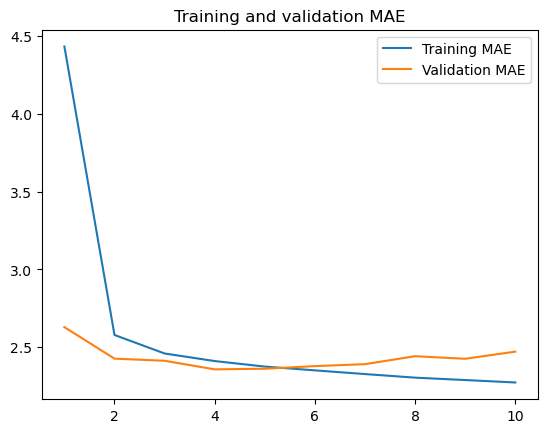

In [30]:
plot_history(history)

In [28]:
model = tf.keras.models.load_model(base_dir / "jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 13s 29ms/step - loss: 10.7969 - mae: 2.5951
Test MAE: 2.60


---

## 10.3 Understanding recurrent neural networks

The dense, fully connected layers and the convnet layers have no memory.

These feedforward networks process each input in turn with no information transfer.

A recurrent neural network (RNN) retains information of past inputs.

The RNN has a **feedback loop**, and the **parameters are shared** (the same at each iteration).

(Saves a lot of parameters, like in CNNs.)

<!-- ![RNN unrolled](images/rnn/RNN-unrolled.png) -->
![RNN unrolled](https://drive.google.com/uc?id=1PquEvBt7rHv7I3XJxHTI8uV9YxvBa-B0)

<small>[Olah, "Understanding LSTM Networks"](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)</small>


The activation $h_{t-1}$ at time $t-1$ is fed back to the input and combined with the new input $x_t$, at time $t$.

The previous activation (layer output) is called the **state** of the unit.

The previous activation/state is weighted and the network learns correlations with earlier inputs by adjusting these weights, in the usual manner.

Here, we imagine that sequence terms $x_1, x_2, x_3, \ldots$ etc. occur at successive times, (even if the sequence is not chronological).

Previously, in a feed forward networks, the entire sequence (review) was treated as a single input vector!

#### Note

The state is reset before a new sequence is processed (if don't do that your RNN is called **stateful**).


<!-- <img style="height:750px" src="images/rnn/mit.rnn.png"> -->
<img style="height:750px" src="https://drive.google.com/uc?id=1Sd1CD6t25ME7EWHla4SoCHBUDQQ7P4La">

<small>[Ava Soleimany, MIT 6.S191 (2021): Recurrent Neural Networks](https://www.youtube.com/watch?v=qjrad0V0uJE)</small>

##### The standard recurrent layer

There are two inputs: the **current input**, $x_t$, and the **previous state**, $h_{t-1}$.

The state (= activation) of the RNN layer is:

$$
\bbox[5px,border:2px solid red]
{
\begin{align*}
h_t &= f(W \cdot x_t + U \cdot \color{green}{h_{t-1}} + b_h)  \\
\end{align*}
}
$$

$f$: typically: $\color{red}{tanh}$, also sometimes $relu$.  
W is an $M \times N$ matrix – a tensor with shape `(output_features, input_features)`.  
U is an $M \times M$ matrix – a tensor with shape `(output_features, output_features)`.  

$N$: number of input features  
$M$: number of output features = number of units  


##### Note

That was the **internal mechanism** for the state. To *use* this state and turn it into a prediction, you apply yet another typical operation like so:

$$
\bbox[5px,border:2px solid red]
{
\begin{align*}
y_t &= \sigma(V \cdot h_t + b_y) 
\end{align*}
}
$$

$\sigma$: $softmax$, $sigmoid$, depending on your needs.  
V is an $O \times M$ matrix – a tensor with shape `(task_features, output_features)`.  


The previous activation, $h_{t-1}$, can have more or less effect on the current activation.

The influence of the previous activation and input is controlled by the weights.

$
\begin{align*}
The\ recursion: \quad h_t &= f(x_t, \color{blue}{h_{t-1}}) \\
      &= f(x_t, \color{blue}{f( x_{t-1},  \color{green}{h_{t-2}})} ) \\
      &= f( x_t,  \color{blue}{ f( x_{t-1},   \color{green}{f(x(t-2), \color{red}{h_{t-3}}) } ) } ) \\ 
      &= \ldots
\end{align*}
$

In principle, all previous activations, even those reaching far back into the past, can influence the present.


**However**, because of the repeated multiplications involved in the gradient calculation, we quickly get either very large or very small numbers. This is known as the **exploding/vanishing gradient problem**.

The simple RNN layer in pseudocode is:

```python
prev_output = 0
for input_t in input_sequence:
                        # ↓ current input | ↓ previous state
    output_t = activation(dot(W, input_t) + dot(U, prev_output) + b)
    prev_output = output_t
```

#### NumPy implementation of a simple RNN

In [32]:
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

More details in [this notebook](https://drive.google.com/file/d/1CFAld26ZxzR2k74FxIPrW0830o5Amv2A/view?usp=share_link).

#### \# Learnable parameters


\begin{align*}
RNNparams &= current + bias + previous\\
 &= (M \times N + M) + (M \times M)\\
 &= (M \times N) + (M \times M) + M\\ 
 &= \bbox[5px,border:2px solid red]{(N + M + 1) \times M}\\
\end{align*}


$N$: number of input features  
$M$: previous output = number of units

Each neuron has $N$ weights for the $N$ input features, $M$ weights for the previous output, and a bias, so $(N + M + 1)$ parameters, but there are $M$ units!

In [30]:
steps = 120
num_features = 32
num_units = 16
inputs = tf.keras.Input(shape=(steps, num_features))
                            # the default
outputs = tf.keras.layers.SimpleRNN(num_units, return_sequences=False)(inputs)
model = tf.keras.Model(inputs,outputs)
model.summary()

print()
print(f"Number of learnable RNN params, (N + M + 1) * M:   {(num_features + num_units  + 1) * num_units}")
print(f"Note: it's the same same as (M * N + M) + (M * M): {(num_units * num_features + num_units) + (num_units * num_units)}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 32)]         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                784       
                                                                 
Total params: 784
Trainable params: 784
Non-trainable params: 0
_________________________________________________________________

Number of learnable RNN params, (N + M + 1) * M:   784
Note: it's the same same as (M * N + M) + (M * M): 784


### LSTM: Long Short Term Memory

Fully-fledged recurrent nets: LSTMs have a **memory** or **carry** ($C_t$) – passing information forward in time, like a conveyor belt, with potentially no modification – and **gates** ($\sigma$) acting as smooth on/off switches.

The conveyor belt was developed to solve the **exploding/vanishing gradients problem**!

<!-- ![LSTM](images/rnn/dprogrammer.LSTM.png) -->
 
![LSTM](https://drive.google.com/uc?id=1GauSM-CxE0ERo_C2-EAl180MVHslATpu)

<small>["RNN, LSTM & GRU", dprogrammer.org](http://dprogrammer.org/rnn-lstm-gru)</small>

More details in [this notebook](https://drive.google.com/file/d/1CFAld26ZxzR2k74FxIPrW0830o5Amv2A/view?usp=share_link).

<!-- <img src="images/rnn/mit.lstm.2.png"> -->
<img src="https://drive.google.com/uc?id=1ucHGDyUkS8MH8YuAgOpU0uzzV_YVeOEE">

<small>[Ava Soleimany, MIT 6.S191 (2021): Recurrent Neural Networks](https://www.youtube.com/watch?v=qjrad0V0uJE)</small>

### Gates

Suppose we wish to turn an RNN off or on.

Simple! Multiply by a binary switch: 

$$\delta \times f(t)$$

$\delta$: smooth values between $0, 1$  
$f(t)$: the activation of a simple RNN

What we want:
- the parameters of the switch should be **learnable**;
- because of backpropagation, the process must be **differentiable**: the switch has to be a continuous function – smoothly going from 0 to 1.
  
The smooth activation function that takes values in $[0, 1]$?  
$sigmoid\ (\sigma)$!

#### A learnable gate

$$
\bbox[5px,border:2px solid red]
{
\sigma(z) \odot f(t)
}
$$

$\odot$ : the Hadamard (element-wise) product.


But what is $z$?

We might want (because we are processing sequences) the state of the gate – on, off or in between – to depend on the current input and past activations:

$$
\bbox[5px,border:2px solid red]
{
z = W \cdot x_t + U \cdot h_{t-1} + b
}
$$

Our recurrently gated RNN is: 

$$
\bbox[5px,border:2px solid red]
{
\sigma(W \cdot x_t + U \cdot h_{t-1} + b) \odot f(t)
}
$$ 

$\odot$ : the Hadamard (element-wise) product.


#### \# Learnable parameters


The LSTM follows the same logic as the vanilla RNN, all gates and simple RNN layers have their own parameters $(W, U, b)$, but with **four** internal matrices.

There are four $(W, U, b)$ units – 3 gates and the simple RNN, $f$. Each set of $(W, U, b)$ units has $(N + M + 1) \times M$ trainable parameters

Therefore: 

$$
LSTMparams = \bbox[5px,border:2px solid red]{((N + M + 1) \times M) \times 4}
$$ 

$N$: input features weights  
$M$: previous output = number of units

In [31]:
steps = 120
num_features = 16
num_units = 8
inputs = tf.keras.Input(shape=(steps, num_features))
                            # the default
outputs = tf.keras.layers.LSTM(num_units, return_sequences=False)(inputs)
model = tf.keras.Model(inputs,outputs)
model.summary()

print()
print(f"Number of learnable LSTM params: { ((num_features + num_units + 1) * num_units) * 4}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 16)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________

Number of learnable LSTM params: 800


<!-- <img src="images/rnn/mit.lstm.8.png"> -->
<img style="height:750px" src="https://drive.google.com/uc?id=1WMf1r4fEapO1kTZLgCGBWzrGq3zcIsvS">

<small>[Ava Soleimany, MIT 6.S191 (2021): Recurrent Neural Networks](https://www.youtube.com/watch?v=qjrad0V0uJE)</small>

### GRU Gated Recurrent Unit

'Optimised' recurrent nets: same logic as LSTM, but with less connections/parameters!

<!-- ![GRU](images/rnn/dprogrammer.GRU.png) -->
 
![LSTM](https://drive.google.com/uc?id=1WzjBl76pPiFkZBmnNiEd_34aqs-ldqV0)

<small>["RNN, LSTM & GRU", dprogrammer.org](http://dprogrammer.org/rnn-lstm-gru)</small>

#### Blog posts

[Olah, "Understanding LSTM Networks"](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)  
[Madsen, "Visualizing memorization in RNNs", Distill](https://distill.pub/2019/memorization-in-rnns/)  
[Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)


### Tutorials

[Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation)  
[TensorFlow Addons Networks : Sequence-to-Sequence NMT with Attention Mechanism](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt)


More details in [this notebook](https://drive.google.com/file/d/1CFAld26ZxzR2k74FxIPrW0830o5Amv2A/view?usp=share_link).

---

### References

More details in [this notebook](https://drive.google.com/file/d/1CFAld26ZxzR2k74FxIPrW0830o5Amv2A/view?usp=share_link).

An [in-depth survey from CS230, Stanford University](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks)


#### RNNs
[Rumelhart, David E; Hinton, Geoffrey E, and Williams, Ronald J (Sept. 1985), "Learning internal representations by error propagation"](https://apps.dtic.mil/dtic/tr/fulltext/u2/a164453.pdf)  
[Jordan, Michael I. (May 1986), "Serial order: a parallel distributed processing approach"](https://www.osti.gov/biblio/6910294)

#### LSTMs
[Sepp Hochreiter, Jürgen Schmidhuber, "Long Short-Term Memory"](https://arxiv.org/abs/2105.06756)

#### GRUs
[Kyunghyun Cho, Bart van Merrienboer, Dzmitry Bahdanau, Yoshua Bengio, "On the Properties of Neural Machine Translation: Encoder-Decoder Approaches"](https://arxiv.org/abs/1409.1259)  
[Ralf C. Staudemeyer, Eric Rothstein Morris, "Understanding LSTM -- a tutorial into Long Short-Term Memory Recurrent Neural Networks", arXiv](https://arxiv.org/abs/1909.09586)  

In [ ]:
YouTubeVideo('qjrad0V0uJE', width=853, height=480) #  MIT 6.S191 (2021): Recurrent Neural Networks 

---

### 10.3.1 A recurrent layer in Keras

#### An RNN layer that can process sequences of any length

In [13]:
num_features = 14            # ↓ we don't need specify the length!
inputs = tf.keras.Input(shape=(None, num_features))
outputs = tf.keras.layers.SimpleRNN(16)(inputs)
print(outputs.shape)

(None, 16)


#### An RNN layer that returns only its last output step

By default RNN layers only return the **last state**.

In [14]:
num_features = 14
steps = 120                  # ↓ but we can also do it
inputs = tf.keras.Input(shape=(steps, num_features))
                                      # ↓ the default!
outputs = tf.keras.layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


#### An RNN layer that returns its full output sequence

If you wish to stack layers of those, all intermediate layers should return their full sequence of outputs.

<img style="float:right;height:400px" src="images/rnn/stanford.stacked-rnns.png">

<small style="position:absolute;bottom:0;right:0">[John Lambert, "Stacked RNNs for Encoder-Decoder Networks: Accurate Machine Understanding of Images", Stanford CS224d, figure 2, p.3](https://cs224d.stanford.edu/reports/Lambert.pdf)</small>

For that,we  specify: 

```python
return_sequences=True
```

In [34]:
num_features = 14
steps = 120
inputs = tf.keras.Input(shape=(steps, num_features))
outputs = tf.keras.layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


#### Stacking RNN layers

In [35]:
inputs = tf.keras.Input(shape=(steps, num_features))
x = tf.keras.layers.SimpleRNN(16, return_sequences=True)(inputs) # return sequences
x = tf.keras.layers.SimpleRNN(16, return_sequences=True)(x)      # return sequences
outputs = tf.keras.layers.SimpleRNN(16)(x)                       # no need in the last layer

---

## 10.4 Advanced use of recurrent neural networks

### 10.4.1 Using recurrent dropout to fight overfitting

> "\[T\]he proper way to use dropout with a
recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of using a dropout mask that varies randomly from timestep to timestep." (DLWP, p.301)

Implemented in Keras recurrent layers:

```python
recurrent_dropout=0.25
```

Don't use regular dropout layers in a stack of RNNs (except at the very end)!

### RNN runtime performance

`recurrent_dropout` is not supported by optimized cuDNN kernels, meaning you do not benefit from the best GPU acceleration. **SLOW!**

If your sequences are **not too long** (~100 steps) – this will increase memory consumption a lot –, and if **your sequence length is known in advance**, you can **unroll** your RNN to have it as one full graph on the GPU.(You still can't use cuDNN kernels, but the graph will optimise things a bit.)


```python
inputs = tf.keras.Input(shape=(sequence_length, num_features))
                                                  # ↓ unroll (memory-greedy!)
x = tf.keras.layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)
```

#### Training and evaluating a dropout-regularized LSTM (0.25)

In [15]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
                           # ↓ recurrent dropout
x = tf.keras.layers.LSTM(32, recurrent_dropout=0.25)(inputs) # Note: recurrent_dropout is INSANELY slow!!
x = tf.keras.layers.Dropout(0.5)(x) # adding dropout at the very end only
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_lstm_dropout.keras",
        save_best_only=True
    )
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
819/819 [==============================] - 330s 401ms/step - loss: 28.5333 - mae: 3.9382 - val_loss: 9.8841 - val_mae: 2.4535
Epoch 2/50
819/819 [==============================] - 328s 401ms/step - loss: 14.8521 - mae: 2.9950 - val_loss: 9.1880 - val_mae: 2.3559
Epoch 3/50
819/819 [==============================] - 328s 400ms/step - loss: 13.8338 - mae: 2.8893 - val_loss: 9.1041 - val_mae: 2.3508
Epoch 4/50
819/819 [==============================] - 327s 399ms/step - loss: 13.1514 - mae: 2.8188 - val_loss: 8.9290 - val_mae: 2.3154
Epoch 5/50
819/819 [==============================] - 326s 398ms/step - loss: 12.6827 - mae: 2.7631 - val_loss: 9.2009 - val_mae: 2.3598
Epoch 6/50
819/819 [==============================] - 340s 416ms/step - loss: 12.3126 - mae: 2.7215 - val_loss: 9.3532 - val_mae: 2.3623
Epoch 7/50
819/819 [==============================] - 328s 400ms/step - loss: 11.8746 - mae: 2.6778 - val_loss: 9.2519 - val_mae: 2.3557
Epoch 8/50
819/819 [=====================

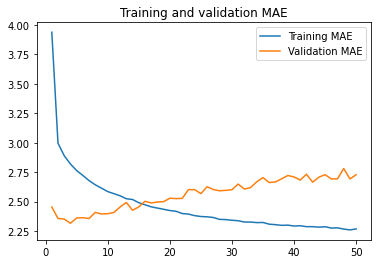

In [20]:
plot_history(history)

In [21]:
model = tf.keras.models.load_model(base_dir / "jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 24s 58ms/step - loss: 10.6964 - mae: 2.5786
Test MAE: 2.58


#### Training and evaluating a dropout-regularized LSTM (0.3)

In [11]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
                           # recurrent dropout is not supported by cuDNN kernels on its own, you can
                           # try add: unroll=True (beware, this is memory-greedy!)    
x = tf.keras.layers.LSTM(32, recurrent_dropout=0.3)(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_lstm_dropout.keras",
        save_best_only=True
    )
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
819/819 [==============================] - 538s 649ms/step - loss: 27.2959 - mae: 3.8580 - val_loss: 9.8704 - val_mae: 2.4392
Epoch 2/50
819/819 [==============================] - 532s 649ms/step - loss: 14.8927 - mae: 2.9939 - val_loss: 9.2503 - val_mae: 2.3619
Epoch 3/50
819/819 [==============================] - 533s 650ms/step - loss: 14.1190 - mae: 2.9137 - val_loss: 9.1531 - val_mae: 2.3579
Epoch 4/50
819/819 [==============================] - 571s 697ms/step - loss: 13.5838 - mae: 2.8541 - val_loss: 9.2043 - val_mae: 2.3627
Epoch 5/50
819/819 [==============================] - 485s 591ms/step - loss: 13.1103 - mae: 2.8031 - val_loss: 9.2886 - val_mae: 2.3833
Epoch 6/50
819/819 [==============================] - 484s 591ms/step - loss: 12.8117 - mae: 2.7668 - val_loss: 9.3372 - val_mae: 2.3815
Epoch 7/50
819/819 [==============================] - 488s 595ms/step - loss: 12.4259 - mae: 2.7232 - val_loss: 9.3503 - val_mae: 2.3782
Epoch 8/50
819/819 [=====================

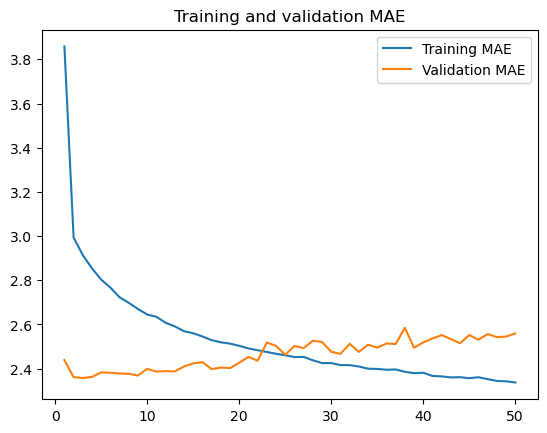

In [13]:
plot_history(history)

In [14]:
model = tf.keras.models.load_model(base_dir / "jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 35s 86ms/step - loss: 10.5548 - mae: 2.5673
Test MAE: 2.57


#### Training and evaluating a dropout-regularized LSTM (0.5)

In [15]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.LSTM(32, recurrent_dropout=0.5)(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_lstm_dropout.keras",
        save_best_only=True
    )
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
819/819 [==============================] - 491s 594ms/step - loss: 30.8981 - mae: 4.0752 - val_loss: 9.8708 - val_mae: 2.4346
Epoch 2/50
819/819 [==============================] - 486s 593ms/step - loss: 15.2343 - mae: 3.0288 - val_loss: 9.4229 - val_mae: 2.3901
Epoch 3/50
819/819 [==============================] - 486s 594ms/step - loss: 14.1941 - mae: 2.9232 - val_loss: 9.3416 - val_mae: 2.3787
Epoch 4/50
819/819 [==============================] - 486s 593ms/step - loss: 13.5473 - mae: 2.8527 - val_loss: 9.1527 - val_mae: 2.3503
Epoch 5/50
819/819 [==============================] - 487s 594ms/step - loss: 13.0330 - mae: 2.8020 - val_loss: 9.3055 - val_mae: 2.3655
Epoch 6/50
819/819 [==============================] - 486s 594ms/step - loss: 12.7337 - mae: 2.7667 - val_loss: 9.3366 - val_mae: 2.3721
Epoch 7/50
819/819 [==============================] - 487s 594ms/step - loss: 12.4665 - mae: 2.7386 - val_loss: 9.3970 - val_mae: 2.3801
Epoch 8/50
819/819 [=====================

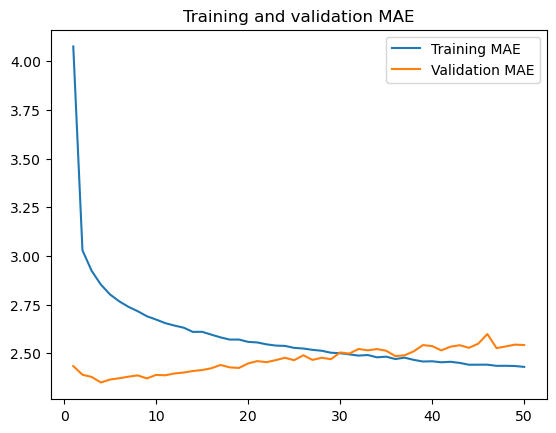

In [17]:
plot_history(history)

In [23]:
model = tf.keras.models.load_model(base_dir / "jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 40s 96ms/step - loss: 12.6225 - mae: 2.8318
Test MAE: 2.83


#### Training and evaluating an LSTM without dropout

In [47]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = tf.keras.layers.LSTM(32)(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [48]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_lstm_no_dropout.keras",
        save_best_only=True
    )
]
model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
819/819 [==============================] - 44s 48ms/step - loss: 26.7083 - mae: 3.8154 - val_loss: 9.7099 - val_mae: 2.4157
Epoch 2/50
819/819 [==============================] - 37s 45ms/step - loss: 14.5428 - mae: 2.9643 - val_loss: 9.7203 - val_mae: 2.4169
Epoch 3/50
819/819 [==============================] - 37s 45ms/step - loss: 13.7138 - mae: 2.8719 - val_loss: 10.0920 - val_mae: 2.4647
Epoch 4/50
819/819 [==============================] - 37s 45ms/step - loss: 13.0375 - mae: 2.7995 - val_loss: 9.4536 - val_mae: 2.3768
Epoch 5/50
819/819 [==============================] - 37s 45ms/step - loss: 12.4251 - mae: 2.7290 - val_loss: 9.9472 - val_mae: 2.4384
Epoch 6/50
819/819 [==============================] - 37s 45ms/step - loss: 11.8576 - mae: 2.6652 - val_loss: 9.7328 - val_mae: 2.4212
Epoch 7/50
819/819 [==============================] - 37s 45ms/step - loss: 11.5404 - mae: 2.6298 - val_loss: 10.0430 - val_mae: 2.4521
Epoch 8/50
819/819 [==============================] -

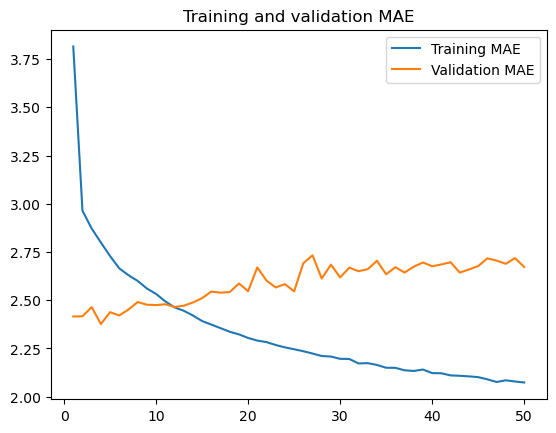

In [50]:
plot_history(history)

In [51]:
model = tf.keras.models.load_model(base_dir / "jena_lstm_no_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 15s 33ms/step - loss: 11.3424 - mae: 2.6750
Test MAE: 2.68


#### Training and evaluating an L2-regularized LSTM

There is also such a thing as a `recurrent_regularizer`! (Works as usual.)

In [66]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
                           # ↓ recurrent regularizer
x = tf.keras.layers.LSTM(32, recurrent_regularizer=tf.keras.regularizers.L2(0.3))(inputs)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [67]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_lstm_l2.keras",
        save_best_only=True
    )
]
model.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
819/819 [==============================] - 55s 61ms/step - loss: 26.8447 - mae: 3.7322 - val_loss: 10.7634 - val_mae: 2.5036
Epoch 2/50
819/819 [==============================] - 58s 70ms/step - loss: 15.3377 - mae: 3.0156 - val_loss: 10.1983 - val_mae: 2.4559
Epoch 3/50
819/819 [==============================] - 52s 63ms/step - loss: 14.6213 - mae: 2.9436 - val_loss: 9.4174 - val_mae: 2.3669
Epoch 4/50
819/819 [==============================] - 43s 52ms/step - loss: 14.1971 - mae: 2.8984 - val_loss: 9.9144 - val_mae: 2.4293
Epoch 5/50
819/819 [==============================] - 48s 59ms/step - loss: 13.8581 - mae: 2.8606 - val_loss: 9.4468 - val_mae: 2.3789
Epoch 6/50
819/819 [==============================] - 41s 50ms/step - loss: 13.5553 - mae: 2.8302 - val_loss: 9.3779 - val_mae: 2.3688
Epoch 7/50
819/819 [==============================] - 45s 55ms/step - loss: 13.3202 - mae: 2.8003 - val_loss: 12.0196 - val_mae: 2.6448
Epoch 8/50
819/819 [==============================] 

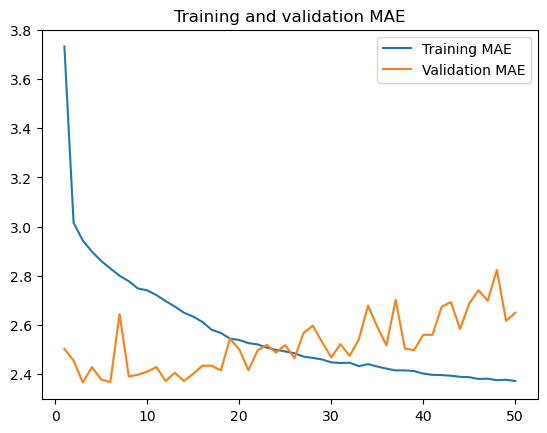

In [68]:
plot_history(history)

In [69]:
model = tf.keras.models.load_model(base_dir / "jena_lstm_l2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 15s 31ms/step - loss: 10.2702 - mae: 2.4884
Test MAE: 2.49


---

### 10.4.2 Stacking recurrent layers

#### Training and evaluating a dropout-regularized, stacked GRU model

In [ ]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
                                                #  we return all inner states
x = tf.keras.layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs) 
x = tf.keras.layers.GRU(32, recurrent_dropout=0.5)(x) # Note: recurrent_dropout is INSANELY slow!!
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [82]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_stacked_gru_dropout.keras",
        save_best_only=True
    )
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
819/819 [==============================] - 63s 67ms/step - loss: 23.7877 - mae: 3.5989 - val_loss: 9.6007 - val_mae: 2.4036
Epoch 2/50
819/819 [==============================] - 48s 58ms/step - loss: 13.5259 - mae: 2.8480 - val_loss: 8.7607 - val_mae: 2.3002
Epoch 3/50
819/819 [==============================] - 52s 63ms/step - loss: 12.6162 - mae: 2.7534 - val_loss: 9.0290 - val_mae: 2.3423
Epoch 4/50
819/819 [==============================] - 51s 62ms/step - loss: 11.8460 - mae: 2.6671 - val_loss: 9.0395 - val_mae: 2.3351
Epoch 5/50
819/819 [==============================] - 52s 63ms/step - loss: 11.1696 - mae: 2.5920 - val_loss: 9.0035 - val_mae: 2.3326
Epoch 6/50
819/819 [==============================] - 50s 61ms/step - loss: 10.5718 - mae: 2.5176 - val_loss: 9.9742 - val_mae: 2.4454
Epoch 7/50
819/819 [==============================] - 50s 61ms/step - loss: 9.9833 - mae: 2.4449 - val_loss: 10.1086 - val_mae: 2.4748
Epoch 8/50
819/819 [==============================] - 4

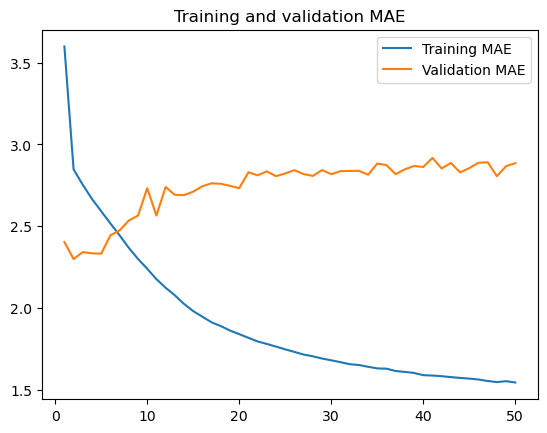

In [83]:
plot_history(history)

In [ ]:
model = tf.keras.models.load_model(base_dir / "jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 16s 33ms/step - loss: 10.0481 - mae: 2.4831
Test MAE: 2.48


#### Training and evaluating an L2-regularized, stacked GRU model

In [122]:
tf.keras.backend.clear_session()

inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))           # we return all inner states
x = tf.keras.layers.GRU(32, recurrent_regularizer=tf.keras.regularizers.l2(0.8), return_sequences=True)(inputs)
x = tf.keras.layers.GRU(32, recurrent_regularizer=tf.keras.regularizers.l2(0.8))(x)
x = tf.keras.layers.Dropout(0.5)(x) # ↑ the L2 regularizer works with cuDNN
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [123]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_stacked_gru_l2.keras",
        save_best_only=True
    )
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
819/819 [==============================] - 54s 51ms/step - loss: 29.5583 - mae: 3.6853 - val_loss: 9.4801 - val_mae: 2.3585
Epoch 2/50
819/819 [==============================] - 39s 48ms/step - loss: 14.2595 - mae: 2.9172 - val_loss: 9.2738 - val_mae: 2.3555
Epoch 3/50
819/819 [==============================] - 44s 54ms/step - loss: 13.7008 - mae: 2.8577 - val_loss: 10.2424 - val_mae: 2.4953
Epoch 4/50
819/819 [==============================] - 45s 55ms/step - loss: 13.1864 - mae: 2.8032 - val_loss: 9.2510 - val_mae: 2.3657
Epoch 5/50
819/819 [==============================] - 45s 54ms/step - loss: 12.8375 - mae: 2.7694 - val_loss: 9.0631 - val_mae: 2.3338
Epoch 6/50
819/819 [==============================] - 45s 54ms/step - loss: 12.5329 - mae: 2.7369 - val_loss: 8.9297 - val_mae: 2.3268
Epoch 7/50
819/819 [==============================] - 45s 55ms/step - loss: 12.2470 - mae: 2.7091 - val_loss: 9.0576 - val_mae: 2.3468
Epoch 8/50
819/819 [==============================] - 

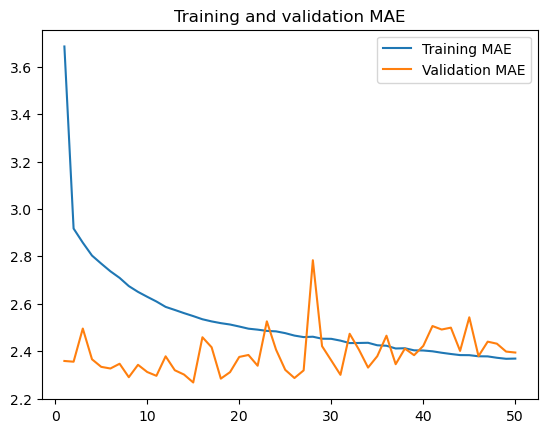

In [124]:
plot_history(history)

In [125]:
model = tf.keras.models.load_model(base_dir / "jena_stacked_gru_l2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 16s 32ms/step - loss: 9.7227 - mae: 2.4296
Test MAE: 2.43


---

### 10.4.3 Using bidirectional RNNs

RNNs exploit patterns in data that has a definite order (like weather readings).

But the **reverse** of an ordered list is still ordered and might hold pertinent information.

The idea is to train one net on sequential data, then another one with **the same hyperparameters** on the same dataset but with the order *reversed*.

The hypothesis is that word order *does* matter in understanding language but *which* order (forward or back) isn't critical (on the basis if this single experiment).

An RNN trained on a reversed sequence will learn different representations than one trained on the original sequence.

Representations that are *different* yet *useful* are always worth exploiting. The more they differ the better!

Alternative representations can capture aspects of the data that were missed by other approaches.

#### Note 

This is the intuition behind *ensembling* (gathering predictions from several models).

A bidirectional RNN is two regular RNNs: one chronological, the other antichronological. Representations are merged at the end.

Strong suit: create representations for the whole sentence (e.g. for sentiment).  
However: cannot be used to predict the next token!

<!-- ![bidirectional rnn](images/rnn/chollet.bidirectional.png) -->
![bidirectional rnn](https://drive.google.com/uc?id=1WbSMJNPjy2tCgHzXqZDCKuB8cvfjjqU2)

<small>DLWP, p.306</small>

#### Training and evaluating a bidirectional LSTM

In [ ]:
inputs = tf.keras.Input(shape=(sequence_length, raw_data.shape[-1]))
                  # ↓ BIDIRECTIONAL -------------------------------
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))(inputs) 
                  # ------------- ↑ wrapping an RNN layer ---------
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [126]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        base_dir / "jena_lstm_bidirectional.keras",
        save_best_only=True
    )
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

Epoch 1/10
819/819 [==============================] - 60s 61ms/step - loss: 26.4216 - mae: 3.6921 - val_loss: 11.4313 - val_mae: 2.6293
Epoch 2/10
819/819 [==============================] - 46s 56ms/step - loss: 9.5115 - mae: 2.4129 - val_loss: 10.4757 - val_mae: 2.5242
Epoch 3/10
819/819 [==============================] - 47s 57ms/step - loss: 8.4618 - mae: 2.2687 - val_loss: 9.8176 - val_mae: 2.4496
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 7.9159 - mae: 2.1893 - val_loss: 9.9030 - val_mae: 2.4602
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 7.4896 - mae: 2.1289 - val_loss: 10.2907 - val_mae: 2.5108
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 7.1696 - mae: 2.0835 - val_loss: 10.7141 - val_mae: 2.5476
Epoch 7/10
819/819 [==============================] - 47s 57ms/step - loss: 6.9118 - mae: 2.0426 - val_loss: 10.7991 - val_mae: 2.5762
Epoch 8/10
819/819 [==============================] - 45

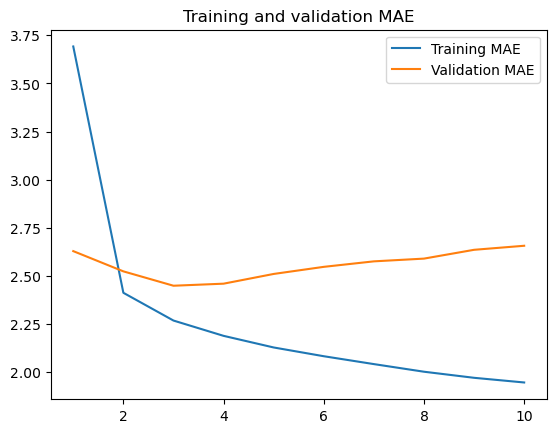

In [127]:
plot_history(history)

In [128]:
model = tf.keras.models.load_model(base_dir / "jena_lstm_bidirectional.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}") 

405/405 [==============================] - 13s 28ms/step - loss: 10.8978 - mae: 2.6199
Test MAE: 2.62


---

### 10.4.4 Going even further

- Experiment with the number of units in recurrent layers, and with dropout;
- Experiment with the optimizer and learning rate;
- Try and have a stack of Dense layers instead of just one;
- Vary the length of input sequences, try a different sampling rate, or think about feature engineering.

## Summary

### As always

- *Baselines, baselines, baselines*;
- Try simple models, then more complex ones;

### RNNs

- Recurrent nets work well for data where **ordering** matters;
- Two main layers:
  - **LSTM**: most complex, most expensive;
  - **GRU**: slightly less complex, faster;
- For recurrent nets use the time-constant `recurrent_dropout` (slow!) or the `recurrent_regularizer`;
- For more representational power, try **stacking** RNN layers
- if you're not predicting future steps, **bidirectional** layers.